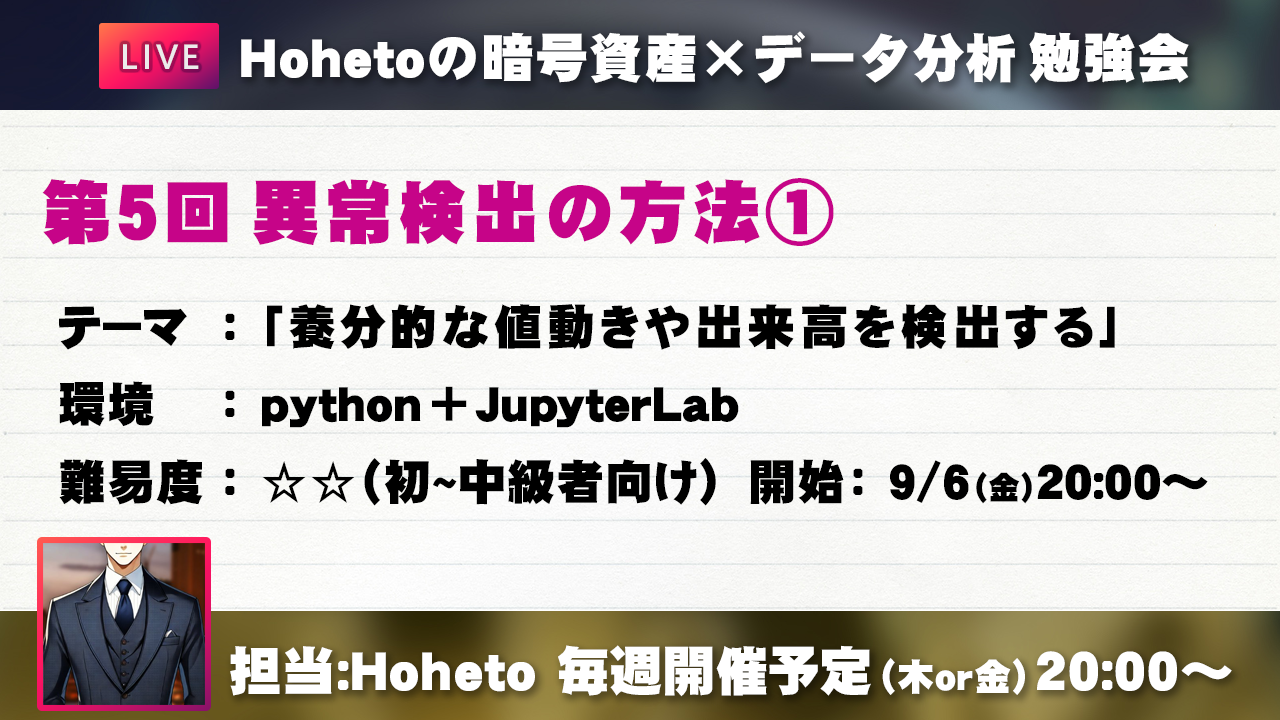

In [1]:
from IPython.display import Image

Image('./images/05_00.png')

# Hoheto勉強会 第5回 異常検出の方法①

## 免責事項

- この勉強会では、過去のデータ分析を中心に行います。未来の値動きを断定したり投資に関するアドバイスを提供するものではありません。
- 投資は自己責任です。この内容に基づいて視聴者様が行う投資判断やその結果について、配信者は一切の責任を負いません。
- 内容には細心の注意を払っておりますが、正確性を完全に保証するものではありません。

## 前提知識

- Python。pandas、numpyなどのライブラリ。
- Jupyter。

## 難易度

- 難易度☆☆2つ。
- 簡単な内容ではありますが、少し実践的な内容になります。

## 今回の内容

- 異常検出の概要と使いどころについて確認します。
- 異常検出の手法について、体系立てて整理します。
- その中から、統計的手法について2通りのやり方をピックアップして、内容を確認します。

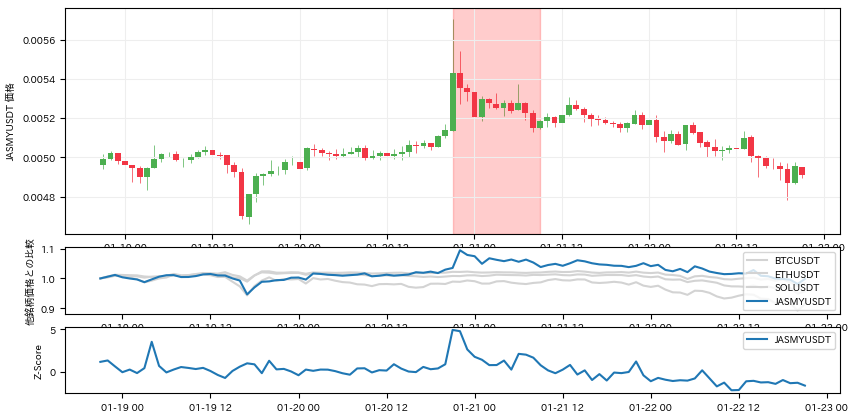

In [2]:
Image('./images/05_06.png')

### 元ネタ

- 今回の元ネタは・・・
- 特になし。たまたま思いついたため。

# 環境設定

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import ccxt
import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import warnings
from datetime import datetime, timedelta
from tqdm import tqdm
from IPython.display import display, HTML, Image

In [5]:
# warning表示off
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 7

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (4, 4)

# データの取得

- 今回は、Binance USDMに上場している全てのアルトコインのデータを使います。
- 合計306銘柄。
- 2024年1月1日～1時間足データ。
- pickleにしているので、ロードします。

In [6]:
import pickle

def load_pickle(path):
    with open(path, mode="rb") as f:
        data = pickle.load(f)
        return data

- pickleからロード。

In [7]:
candles_1h = load_pickle('./data/05_candles_1h.pkl')

- 辞書形式で、各銘柄のOHLCVがDataFrame形式で保存されています。

In [8]:
len(candles_1h)

274

In [9]:
candles_1h.keys()

dict_keys(['ENJUSDT', 'EGLDUSDT', 'ALICEUSDT', 'AMBUSDT', 'DARUSDT', '1INCHUSDT', 'CAKEUSDT', 'SUPERUSDT', 'SUSHIUSDT', 'MKRUSDT', 'NEARUSDT', 'LUNA2USDT', 'ROSEUSDT', 'BLURUSDT', 'NEOUSDT', 'CRVUSDT', 'FTMUSDT', 'ENSUSDT', 'AXSUSDT', 'EOSUSDT', 'C98USDT', 'LRCUSDT', 'BELUSDT', 'LQTYUSDT', 'HIFIUSDT', 'SANDUSDT', 'BALUSDT', 'CKBUSDT', '1000SATSUSDT', 'COTIUSDT', 'TIAUSDT', 'LEVERUSDT', 'RENUSDT', 'UMAUSDT', 'USDCUSDT', 'ARBUSDT', 'WAXPUSDT', 'QNTUSDT', 'UNIUSDT', 'ICPUSDT', 'AAVEUSDT', 'BLZUSDT', 'IMXUSDT', 'KASUSDT', 'BSVUSDT', 'IOTXUSDT', 'PYTHUSDT', 'DUSKUSDT', '1000SHIBUSDT', 'XRPUSDT', 'DASHUSDT', 'DYDXUSDT', 'SEIUSDT', 'PENDLEUSDT', 'EDUUSDT', 'UNFIUSDT', 'JTOUSDT', 'WOOUSDT', 'LTCUSDT', 'FXSUSDT', 'NKNUSDT', 'GMTUSDT', 'XTZUSDT', 'XVSUSDT', 'KNCUSDT', 'ZRXUSDT', 'MASKUSDT', 'XEMUSDT', 'MANAUSDT', 'ONTUSDT', 'THETAUSDT', 'AGLDUSDT', '1000XECUSDT', 'DENTUSDT', 'SOLUSDT', '1000LUNCUSDT', 'PERPUSDT', 'IOSTUSDT', 'SPELLUSDT', 'BAKEUSDT', 'SFPUSDT', '1000FLOKIUSDT', 'SNXUSDT', 'KLAYUS

- DataFrameの例。

In [10]:
candles_1h['ETHUSDT']

,open_price,high_price,low_price,close_price,volume
2024-01-01 00:00:00+00:00,2283.84,2299.16,2282.97,2297.41,75593.183
2024-01-01 01:00:00+00:00,2297.41,2308.74,2294.77,2305.71,58591.895
2024-01-01 02:00:00+00:00,2305.72,2306.95,2293.15,2295.19,44611.328
2024-01-01 03:00:00+00:00,2295.19,2296.83,2272.04,2275.59,88559.028
2024-01-01 04:00:00+00:00,2275.59,2281.71,2266.67,2281.45,80010.451
...,...,...,...,...,...
2024-08-24 19:00:00+00:00,2781.73,2799.23,2780.84,2791.25,44764.006
2024-08-24 20:00:00+00:00,2791.25,2806.62,2787.82,2789.81,72726.570
2024-08-24 21:00:00+00:00,2789.81,2790.72,2729.15,2737.65,195794.183
2024-08-24 22:00:00+00:00,2737.63,2757.60,2735.19,2750.35,101671.758


## OHLCをプロットする

- ローソク足を自炊するプログラム。
- ※簡易的なものです。

In [11]:
def plot_ohlc(ax, df_org, title=''):
    df = df_org.copy()
    interval_sec = (df.index[1] - df.index[0]).total_seconds()
    ax.grid(color='#eeeeee')
    ax.set_title(title)
    # ローソク足の幅を設定
    # matplotlib上でwidth=1->1日となるのでローソク足の時間軸に応じて幅を設定
    w = interval_sec / (24 * 60 * 60)
    # ローソク足
    # 陽線と陰線で色を変えるため、それぞれのindexを取得
    idx1 = df.index[df['close_price'] > df['open_price']]
    idx0 = df.index[df['close_price'] < df['open_price']]
    idx2 = df.index[df['close_price'] == df['open_price']]
    # 実体
    df['body'] = np.abs(df['close_price'] - df['open_price'])
    ax.bar(idx1, df.loc[idx1, 'body'], width=w * (1 - 0.2), bottom=df.loc[idx1, 'open_price'], linewidth=1, color='#4caf50', zorder=2)
    ax.bar(idx0, df.loc[idx0, 'body'], width=w * (1 - 0.2), bottom=df.loc[idx0, 'close_price'], linewidth=1, color='#f23645', zorder=2)
    ax.bar(idx2, 0.005, width=w * (1 - 0.2), bottom=df.loc[idx2, 'close_price'], linewidth=1, color='#666666', zorder=2)
    # ヒゲ
    # ax.vlines(df.index, df['low_perp'], df['high_perp'], linewidth=0.5, color='#666666', zorder=1)
    ax.vlines(idx1, df.loc[idx1, 'low_price'], df.loc[idx1, 'high_price'], linewidth=0.5, color='#4caf50', zorder=1)
    ax.vlines(idx0, df.loc[idx0, 'low_price'], df.loc[idx0, 'high_price'], linewidth=0.5, color='#f23645', zorder=1)
    ax.vlines(idx2, df.loc[idx2, 'low_price'], df.loc[idx2, 'high_price'], linewidth=0.5, color='#666666', zorder=1)


- 以下のように、axisとDataFrameを指定してプロットします。
- ちなみにplt.gca()は、「get_current_axis」ぽい。

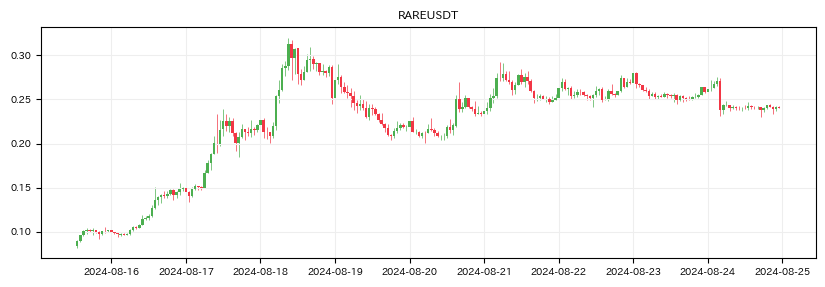

In [12]:
plt.figure(figsize=(10, 3))
plot_ohlc(plt.gca(), candles_1h['RAREUSDT'], title='RAREUSDT');

# 異常検出の概要と使いどころ

## ファイナンシャルデータにおける異常検出とは

- 正常なパターンから外れる異常なデータポイントやイベントを検出する。
- ファイナンシャルな領域では、
  - 市場の急激な変動の検知
  - 異常は不正取引、など。


- 参考）以前noteで公開した、VPIN
- VPINによるパンプ検出と仮想通貨トレードへの応用 [ https://note.com/hht/n/n64cc4d9fcc60 ]
- VPINとは
  - 約定履歴の買い・売りの不均衡さをリアルタイムで計測して、大きな変化の予兆を捉えるもの。

- VPINによる急変検出の例

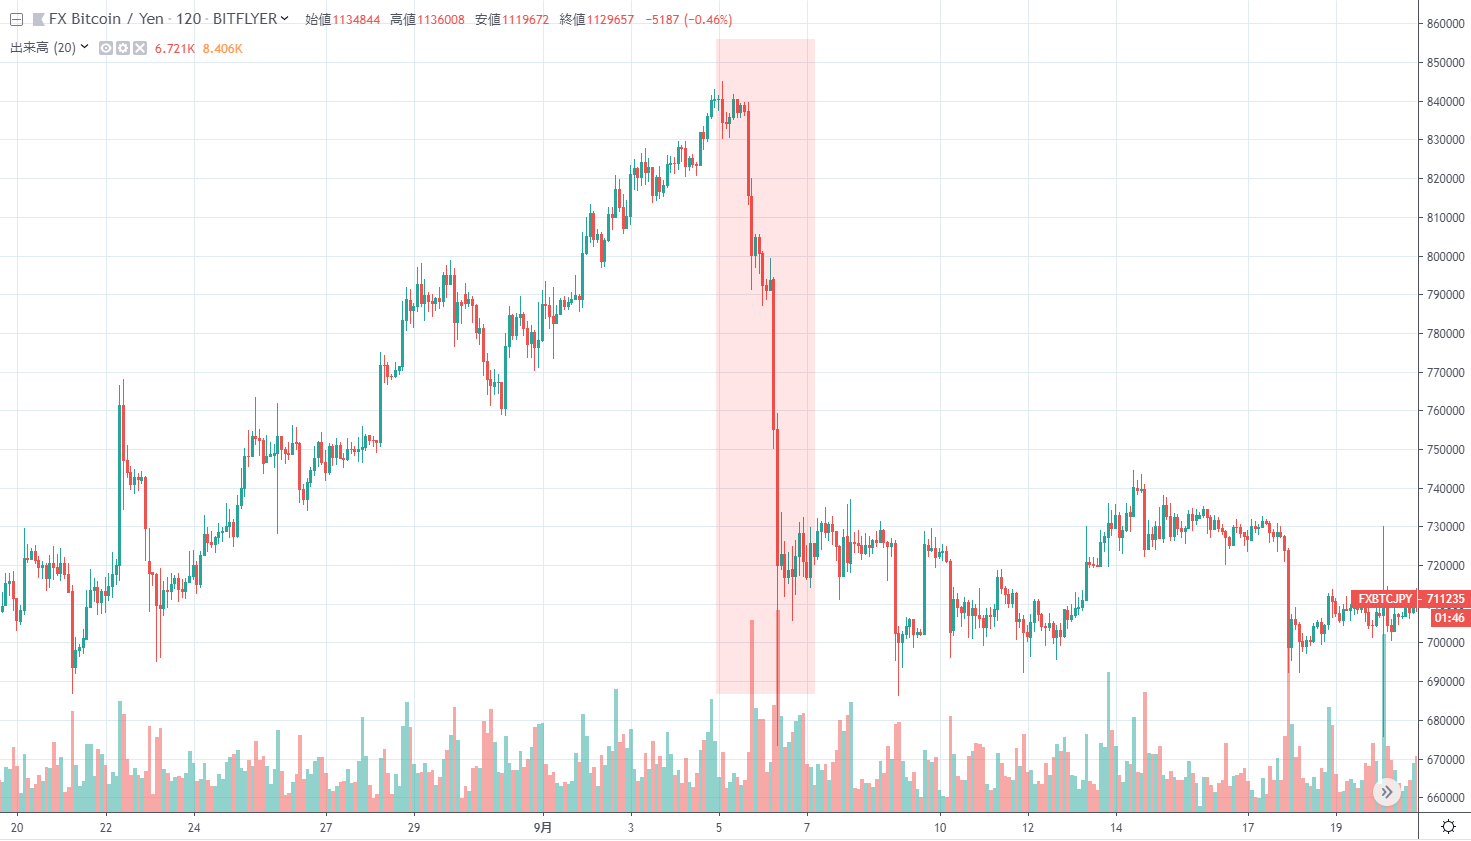

In [13]:
Image('./images/05_01.png', width=700)

## 使いどころ

- 金融時系列データは定常でない（時期に応じてその分布や特徴が異なる）。
  - 例）明らかに、凪相場とバブル相場では、特徴が異なる。
- 異常検出を行うことにより、
  - 通常は、リスクコントロールに使う（急な変動を回避する、など）
  - 分析時は、異常値の除去など
  - ボットへの応用としては、レジームスイッチに使う（戦略やヘッジの切り替えなど）、急変を収益化する（難しい）など。

- 使いどころは多岐にわたる。

# 異常検出の手法

## 統計的手法

- ラベルありの場合（サンプルデータがあらかじめ正常時、異常時に分類済の場合）
  - 正常時の分布、異常時の分布について、それぞれモデリングする。
  - ある事象が起こったとき、その事象が正常時の分布に当てはまる確率（尤度）と、異常時の分布に当てはまる確率を計算する。
  - その比率の対数を異常度とし、閾値を超えた時点で異常とする。
- 図は「異常検知と変化検知(井手 剛著)」より抜粋 [ https://www.amazon.co.jp/dp/4061529080 ]

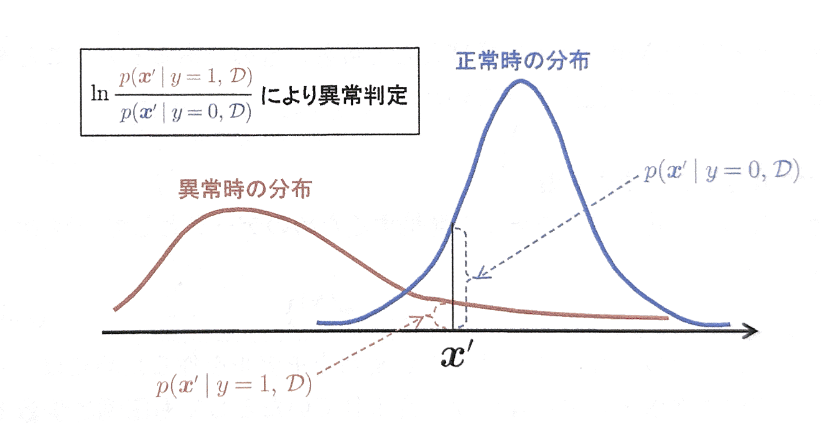

In [14]:
Image('./images/05_03.png', width=600)

- ラベルなしの場合（サンプルデータはラベル付けされていないが、その中に含まれる異常データが十分少ない場合）
  - 全体を確率モデルとしてモデリングする。
  - 「ごくわずかな確率で起こる事象」を異常として検出する。
- 各データを正規分布に近似して多変量正規分布モデルとして扱う。

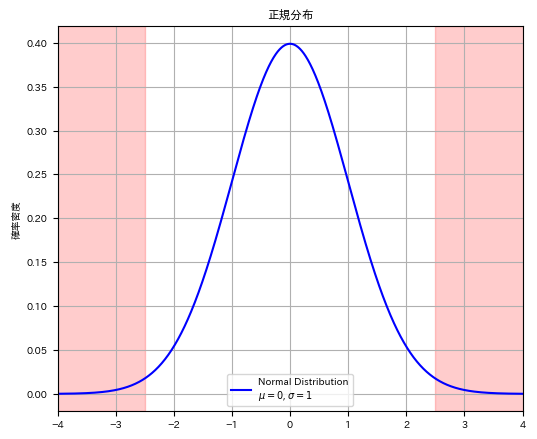

In [15]:
Image('./images/05_04.png', width=500)

## 機械学習を用いた手法

- 教師あり学習、半教師あり学習
  - 普通に特徴量エンジニアリングからのMLモデル。
  - あるいはRNNなどの時系列系ニューラルネットワークモデル。

- 教師なし学習（自動で分類）
  - クラスタリング
    - 各銘柄の値動きや出来高の特徴をクラスタリングし、他のクラスタから大きく外れたデータポイントを異常とする。
    - k-means、ナイーブベイズなど。

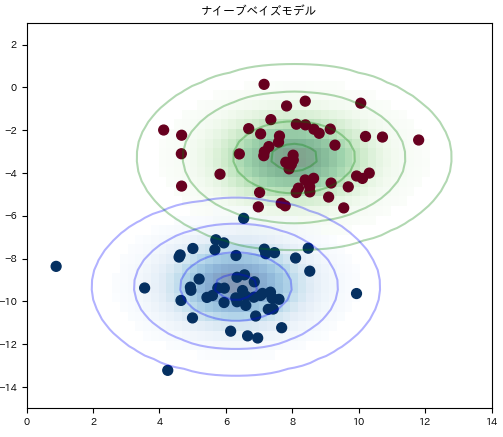

In [16]:
Image('./images/05_05.png', width=500)

- 生成モデル
  - 時系列データを正常データを中心に学習させたエンコーダーで圧縮したあとにデコーダーで復元する。
  - で、原系列と比較して差分を確認し、新規性や異常性を検出する。
- 生成モデルの例
  - 経済金融時系列における歪みの検出 [ https://www.jstage.jst.go.jp/article/jsaisigtwo/2020/FIN-024/2020_157/_pdf/-char/ja ]
  - 2019年5月ごろ、イレギュラーな原油の下落を検出した例（当時、トランプ大統領による原油増産への圧力があった）

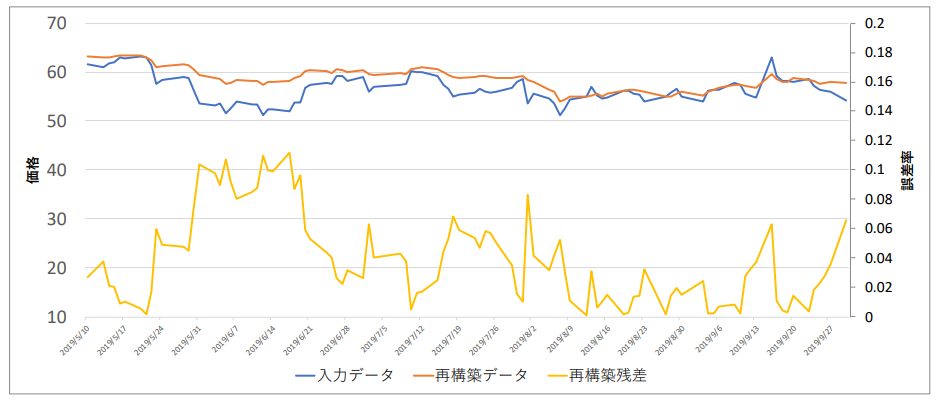

In [17]:
Image('./images/05_02.png', width=700)

# 異常検出の例1

## 価格に対する異常検知

- 平均と標準偏差を利用した、異常値検出。
- つまりこれはボリンジャーバンド。
- 3σを異常箇所としてプロットしてみる。

In [18]:
sol_1h = candles_1h['SOLUSDT'].copy()

# 移動平均と標準偏差
window = 20
sol_1h['open_price_sma'] = sol_1h['open_price'].rolling(window).mean()
sol_1h['open_price_std'] = sol_1h['open_price'].rolling(window).std()

# 上限と下限の計算
sol_1h['upper'] = sol_1h['open_price_sma'] + 3 * sol_1h['open_price_std']
sol_1h['lower'] = sol_1h['open_price_sma'] - 3 * sol_1h['open_price_std']

# 異常値の検出
sol_1h['anomaly'] = (sol_1h['open_price'] > sol_1h['upper']) | (sol_1h['open_price'] < sol_1h['lower'])

- （価格-移動平均）／標準偏差　の分布。
- 移動平均の遅行性により正規分布にはなっていないことに注意。

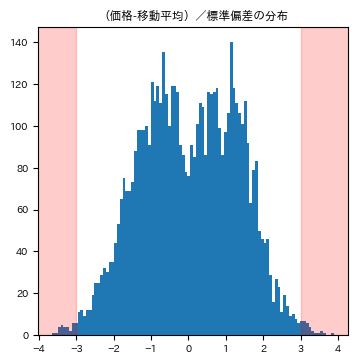

In [19]:
plt.title('（価格-移動平均）／標準偏差の分布')
((sol_1h['open_price'] - sol_1h['open_price_sma']) / sol_1h['open_price_std']).hist(bins=100)
plt.axvspan(-5, -3, color='red', alpha=0.2)
plt.axvspan(3, 5, color='red', alpha=0.2)
plt.grid(False);

- 始め値が3σを超えた場所をプロットしてみる

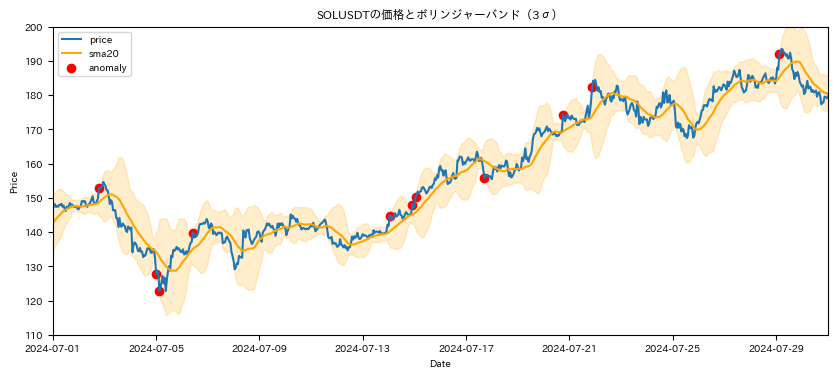

In [20]:
# グラフの描画
plt.figure(figsize=(10, 4))
plt.plot(sol_1h.index, sol_1h['open_price'], label='price')
plt.plot(sol_1h.index, sol_1h['open_price_sma'], label='sma20', color='orange')
plt.fill_between(sol_1h.index, sol_1h['upper'], sol_1h['lower'], color='orange', alpha=0.2)
plt.scatter(sol_1h[sol_1h['anomaly']].index, sol_1h[sol_1h['anomaly']]['open_price'], color='red', label='anomaly', marker='o')
plt.title('SOLUSDTの価格とボリンジャーバンド（3σ）')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xlim(pd.to_datetime('2024-07-01'), pd.to_datetime('2024-07-31'))
plt.ylim(110, 200)
plt.legend()
plt.show()

- ローソク足と出来高で確認。

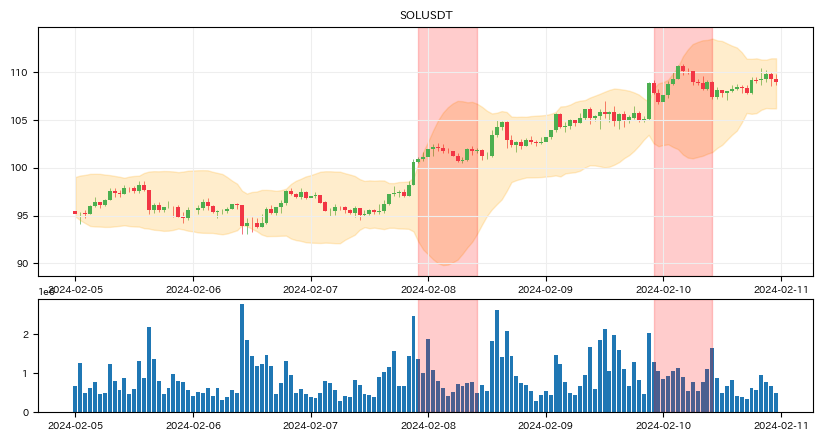

In [21]:
tmp = sol_1h['2024-02-05':'2024-02-10']
plt.figure(figsize=(10, 5))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
plot_ohlc(ax1, tmp, title='SOLUSDT')
ax1.fill_between(tmp.index, tmp['upper'], tmp['lower'], color='orange', alpha=0.2)
for idx in tmp[tmp['anomaly']].index:
  ax1.axvspan(idx, idx+timedelta(hours=12), color='red', alpha=0.2)
ax2 = plt.subplot2grid((3, 1), (2, 0))
ax2.bar(tmp.index, tmp['volume'], width=(1/24)*0.8)
for idx in tmp[tmp['anomaly']].index:
  ax2.axvspan(idx, idx+timedelta(hours=12), color='red', alpha=0.2)
plt.show();

## まとめと課題

- 古典的な手法として、価格の大きな変化を検知はできる。できるのだが…
- 「養分的な値動きを検出する」という今回の目的は達成できていない。
- 結局マーケットが動いたときに、多数の銘柄で同じタイミングで異常が検出される。

# 異常検出の例2

- 銘柄独自の値動きの検出を試みる。
- 多数の銘柄からZスコアを算出する。

- Zスコアとは
  - 標準得点。複数銘柄が存在する中で、自分がどの程度の点を取得しているかを相対的に表す。
  - 横方向の標準化

## VolumeだけのDataFrameを作成

In [22]:
volumes = pd.DataFrame({symbol: df['volume'] for symbol, df in candles_1h.items()})

In [23]:
volumes

,ENJUSDT,EGLDUSDT,ALICEUSDT,AMBUSDT,DARUSDT,1INCHUSDT,CAKEUSDT,SUPERUSDT,SUSHIUSDT,MKRUSDT,...,GUSDT,RAREUSDT,SYNUSDT,SYSUSDT,VOXELUSDT,BRETTUSDT,ALPACAUSDT,POPCATUSDT,SUNUSDT,VIDTUSDT
2024-01-01 00:00:00+00:00,3612170.0,34561.0,200997.0,41134513.0,1946842.2,106594160.0,491708.0,832109.0,2249617.0,4154.669,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-01 01:00:00+00:00,1085953.0,30266.9,220462.6,25637642.0,1240991.7,41688067.0,300895.0,474374.0,975761.0,4241.587,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-01 02:00:00+00:00,1820274.0,16484.7,115567.8,17763184.0,1147062.6,35645345.0,430658.0,538649.0,677320.0,1805.226,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-01 03:00:00+00:00,1726205.0,27081.9,224131.6,74064594.0,2134728.6,46273270.0,751033.0,591547.0,1676221.0,2819.421,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-01 04:00:00+00:00,2382993.0,58145.0,184166.6,88982571.0,3997900.3,36819650.0,921523.0,840622.0,2189005.0,2912.847,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-24 19:00:00+00:00,947252.0,16850.5,136149.1,39084107.0,5592599.5,703920.0,471254.0,1494521.0,529600.0,396.396,...,12093428.0,35927233.0,3584025.0,25896936.0,34600559.0,4130421.0,111543386.0,8535662.0,388545682.0,553545408.0
2024-08-24 20:00:00+00:00,1756010.0,12542.9,174489.7,48844961.0,4345804.3,1319256.0,540247.0,3630203.0,364981.0,490.643,...,7623133.0,21665853.0,993257.0,13255017.0,20992470.0,7255635.0,112713313.0,4164523.0,580955510.0,485497341.0
2024-08-24 21:00:00+00:00,5303764.0,37177.1,1005681.4,115332068.0,24214447.9,6323501.0,955212.0,3999510.0,1274875.0,2364.996,...,18041118.0,69561846.0,4914119.0,19700678.0,15009897.0,28074293.0,72616025.0,6444408.0,912690725.0,174248842.0
2024-08-24 22:00:00+00:00,3299489.0,11917.1,565630.0,54803635.0,13694200.8,2514430.0,508382.0,1571753.0,666952.0,1002.904,...,5984212.0,45253729.0,1536307.0,9145855.0,10416426.0,8115095.0,73073497.0,5316495.0,506519618.0,105805921.0


## データ変換

### 生データ

- Volumeデータは正規分布ではない。

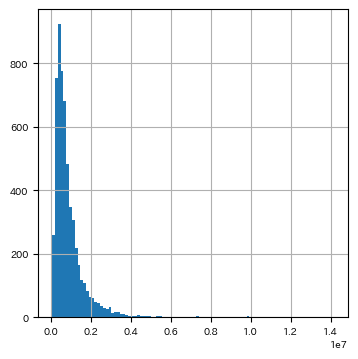

In [24]:
volumes['SOLUSDT'].hist(bins=100);

- 単純にそれぞれのVolumeをプロットしてみると、
- 当然銘柄ごとの粒がそろっていない

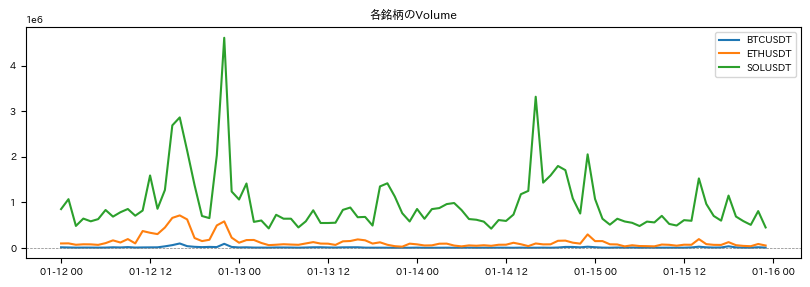

In [25]:
plt.figure(figsize=(10, 3))
start = '2024-01-12'
end = '2024-01-15'
plt.title('各銘柄のVolume')
plt.plot(volumes['BTCUSDT'][start:end], label='BTCUSDT')
plt.plot(volumes['ETHUSDT'][start:end], label='ETHUSDT')
plt.plot(volumes['SOLUSDT'][start:end], label='SOLUSDT')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.legend();

### 直近の平均との比率を取る

- それぞれの移動平均で割って比率にする

In [26]:
volumes_ratio = volumes / volumes.rolling(24*3).mean()

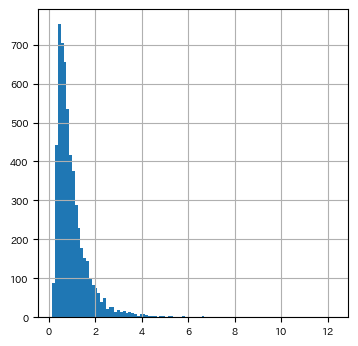

In [27]:
volumes_ratio['SOLUSDT'].hist(bins=100);

- 正規分布にはなっていないが、銘柄ごとの粒度はそろった。
- これで異常が起こっている銘柄を視認できる。

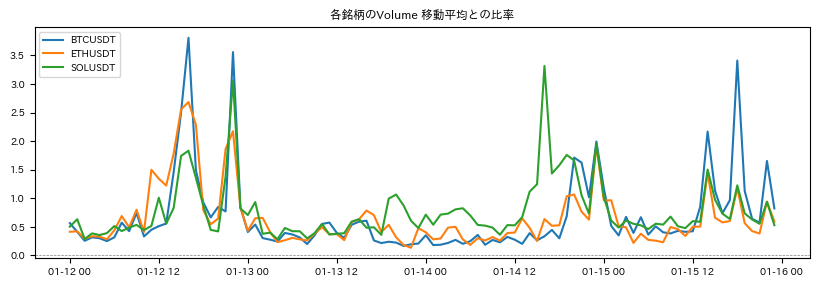

In [28]:
plt.figure(figsize=(10, 3))
start = '2024-01-12'
end = '2024-01-15'
plt.title('各銘柄のVolume 移動平均との比率')
plt.plot(volumes_ratio['BTCUSDT'][start:end], label='BTCUSDT')
plt.plot(volumes_ratio['ETHUSDT'][start:end], label='ETHUSDT')
plt.plot(volumes_ratio['SOLUSDT'][start:end], label='SOLUSDT')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.legend();

### 対数変換する

In [29]:
volumes_log = np.log((volumes+0.00001) / volumes.rolling(24*3).mean())

- 正規分布に近い形状にはなった。
- Volumeは正方向の外れ値に引きずられるので偏った釣り鐘状になっている。
- が、さらに銘柄方向にzスコア化するのでいったんこの状態でOK。
- ちなみに小さな数（0.00001）を足すのは、対数が負の無限大に発散するのを防ぐため。

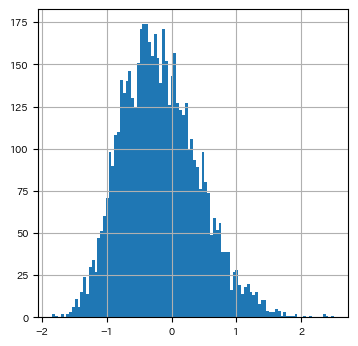

In [30]:
volumes_log['SOLUSDT'].hist(bins=100);

- 対数変換前と比べて、値域が0を中心となっている。

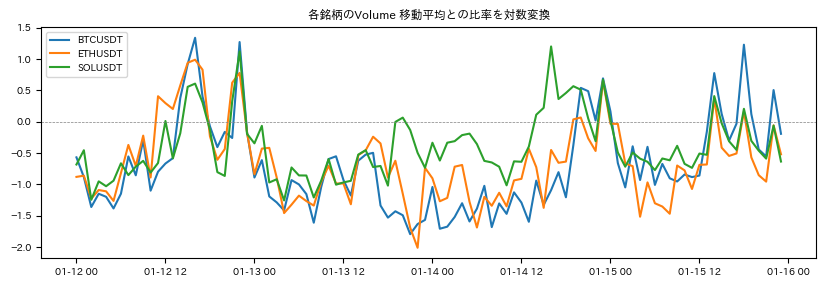

In [31]:
plt.figure(figsize=(10, 3))
start = '2024-01-12'
end = '2024-01-15'
plt.title('各銘柄のVolume 移動平均との比率を対数変換')
plt.plot(volumes_log['BTCUSDT'][start:end], label='BTCUSDT')
plt.plot(volumes_log['ETHUSDT'][start:end], label='ETHUSDT')
plt.plot(volumes_log['SOLUSDT'][start:end], label='SOLUSDT')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.legend();

### Zスコア化

- ここで横方向（各銘柄方向）で標準化を取る（zスコア化）
- これにより、独自の出来高の動きをしている銘柄を調べる。

In [32]:
# Z-Score化
volumes_z = volumes_log.apply(lambda x: (x - np.nanmean(x)) / np.nanstd(x), axis=1)

- この状態で、正の方向の外れ値を異常値とする。
- つまり、他の銘柄と比較し、直近での出来高が異様に増えている銘柄。

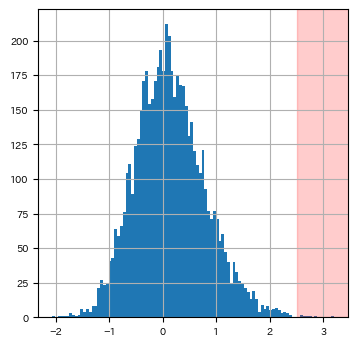

In [33]:
volumes_z['SOLUSDT'].hist(bins=100)
plt.axvspan(2.5, 5, color='red', alpha=0.2);

- ミーム銘柄だと、外れ値が多くなる。

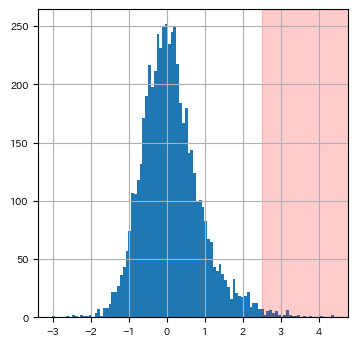

In [34]:
volumes_z['1000PEPEUSDT'].hist(bins=100)
plt.axvspan(2.5, 5, color='red', alpha=0.2);

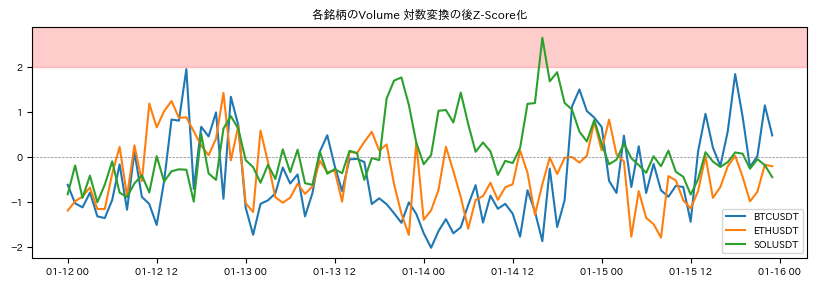

In [35]:
plt.figure(figsize=(10, 3))
start = '2024-01-12'
end = '2024-01-15'
plt.title('各銘柄のVolume 対数変換の後Z-Score化')
plt.plot(volumes_z['BTCUSDT'][start:end], label='BTCUSDT')
plt.plot(volumes_z['ETHUSDT'][start:end], label='ETHUSDT')
plt.plot(volumes_z['SOLUSDT'][start:end], label='SOLUSDT')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axhspan(2, 3, color='red', alpha=0.2)
plt.legend();

## 異常検出

- 異常検出したところのデータを調べる

In [36]:
volumes_anomaly = volumes_z > 2.5
volumes_anomaly

,ENJUSDT,EGLDUSDT,ALICEUSDT,AMBUSDT,DARUSDT,1INCHUSDT,CAKEUSDT,SUPERUSDT,SUSHIUSDT,MKRUSDT,...,GUSDT,RAREUSDT,SYNUSDT,SYSUSDT,VOXELUSDT,BRETTUSDT,ALPACAUSDT,POPCATUSDT,SUNUSDT,VIDTUSDT
2024-01-01 00:00:00+00:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2024-01-01 01:00:00+00:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2024-01-01 02:00:00+00:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2024-01-01 03:00:00+00:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2024-01-01 04:00:00+00:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-24 19:00:00+00:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2024-08-24 20:00:00+00:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2024-08-24 21:00:00+00:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2024-08-24 22:00:00+00:00,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


- 異常が多かった銘柄TOP 20

In [37]:
volumes_anomaly.sum().sort_values(ascending=False).head(20)

BNXUSDT        278
XVSUSDT        276
BLZUSDT        275
FRONTUSDT      270
LSKUSDT        255
AMBUSDT        253
ONGUSDT        250
ARKUSDT        248
USDCUSDT       243
OMUSDT         240
RIFUSDT        235
MTLUSDT        229
USTCUSDT       226
HIFIUSDT       221
GLMUSDT        219
POLYXUSDT      219
ORBSUSDT       215
KEYUSDT        213
BONDUSDT       211
AUCTIONUSDT    207
dtype: int64

- 異常検出できた箇所のインデックスを、銘柄ごとに抜き出し

In [38]:
anomaly_indices = {}
for symbol in volumes_anomaly.columns:
    # 上記で出てきたTrue or FalseのDataFrameに対して、
    # 各カラム事に、一時的な新しいDataFrameを作成
    tmp = volumes_anomaly[[symbol]]
    # 「直近4時間がFalseばかりであるか」のカラムを作成
    tmp['past_4h_signal'] = tmp[symbol].rolling(window=4, min_periods=1).apply(lambda x: x.any() == False, raw=True).shift(1)
    # 「直近4時間がFalseばかり」かつ「True」の行を抜き出し
    tmp = tmp[(tmp['past_4h_signal'] == 1) & (tmp[symbol] == True)]
    if len(tmp) > 0:
        # 「異常ケースのindex」として保持
        anomaly_indices[symbol] = tmp.index

In [39]:
anomaly_indices.keys()

dict_keys(['ENJUSDT', 'EGLDUSDT', 'ALICEUSDT', 'AMBUSDT', 'DARUSDT', '1INCHUSDT', 'CAKEUSDT', 'SUPERUSDT', 'SUSHIUSDT', 'MKRUSDT', 'NEARUSDT', 'LUNA2USDT', 'ROSEUSDT', 'BLURUSDT', 'NEOUSDT', 'CRVUSDT', 'FTMUSDT', 'ENSUSDT', 'AXSUSDT', 'EOSUSDT', 'C98USDT', 'LRCUSDT', 'BELUSDT', 'LQTYUSDT', 'HIFIUSDT', 'SANDUSDT', 'BALUSDT', 'CKBUSDT', '1000SATSUSDT', 'COTIUSDT', 'TIAUSDT', 'LEVERUSDT', 'RENUSDT', 'UMAUSDT', 'USDCUSDT', 'ARBUSDT', 'WAXPUSDT', 'QNTUSDT', 'UNIUSDT', 'ICPUSDT', 'AAVEUSDT', 'BLZUSDT', 'IMXUSDT', 'KASUSDT', 'BSVUSDT', 'IOTXUSDT', 'PYTHUSDT', 'DUSKUSDT', '1000SHIBUSDT', 'XRPUSDT', 'DASHUSDT', 'DYDXUSDT', 'SEIUSDT', 'PENDLEUSDT', 'EDUUSDT', 'UNFIUSDT', 'JTOUSDT', 'WOOUSDT', 'LTCUSDT', 'FXSUSDT', 'NKNUSDT', 'GMTUSDT', 'XTZUSDT', 'XVSUSDT', 'KNCUSDT', 'ZRXUSDT', 'MASKUSDT', 'XEMUSDT', 'MANAUSDT', 'ONTUSDT', 'THETAUSDT', 'AGLDUSDT', '1000XECUSDT', 'DENTUSDT', 'SOLUSDT', '1000LUNCUSDT', 'PERPUSDT', 'IOSTUSDT', 'SPELLUSDT', 'BAKEUSDT', 'SFPUSDT', '1000FLOKIUSDT', 'SNXUSDT', 'KLAYUS

In [40]:
anomaly_indices['1000PEPEUSDT']

DatetimeIndex(['2024-01-09 22:00:00+00:00', '2024-01-10 09:00:00+00:00',
               '2024-01-10 19:00:00+00:00', '2024-01-17 12:00:00+00:00',
               '2024-01-20 23:00:00+00:00', '2024-02-05 11:00:00+00:00',
               '2024-02-05 22:00:00+00:00', '2024-02-12 18:00:00+00:00',
               '2024-02-13 01:00:00+00:00', '2024-02-14 13:00:00+00:00',
               '2024-02-14 21:00:00+00:00', '2024-02-22 23:00:00+00:00',
               '2024-02-23 10:00:00+00:00', '2024-02-26 14:00:00+00:00',
               '2024-02-26 21:00:00+00:00', '2024-02-27 18:00:00+00:00',
               '2024-03-03 10:00:00+00:00', '2024-03-14 03:00:00+00:00',
               '2024-03-30 09:00:00+00:00', '2024-03-31 07:00:00+00:00',
               '2024-04-11 16:00:00+00:00', '2024-04-16 16:00:00+00:00',
               '2024-04-23 13:00:00+00:00', '2024-05-13 12:00:00+00:00',
               '2024-05-13 22:00:00+00:00', '2024-05-14 07:00:00+00:00',
               '2024-05-21 12:00:00+00:00', '2024-0

## プロット

- 異常が検出されたところを中心に、前後2日分をプロット。
  - 異常が検出された銘柄のOHLC
  - BTC、ETHの値動きと、該当の銘柄の値動きを比較
  - Z-Score

In [41]:
def plot_price_and_zscore(anomaly_timestamp, symbol):
    fig = plt.figure(figsize=(10, 5))
    # 前後2日分をプロット
    start = anomaly_timestamp - timedelta(days=2)
    end = anomaly_timestamp + timedelta(days=2)
    # 該当銘柄の価格
    ax1 = plt.subplot2grid((5, 1), (0, 0), rowspan=3)
    ax1.set_ylabel(f'{symbol} 価格')
    plot_ohlc(ax1, candles_1h[symbol][start:end])
    ax1.axvspan(anomaly_timestamp, anomaly_timestamp+timedelta(hours=12), color='red', alpha=0.2)
    # 他の銘柄との価格比較
    ax2 = plt.subplot2grid((5, 1), (3, 0))
    ax2.set_ylabel(f'他銘柄価格との比較')
    ax2.plot(candles_1h['BTCUSDT'][start:end]['open_price'] / candles_1h['BTCUSDT'][start:end]['open_price'][0], label='BTCUSDT', color='lightgray')
    ax2.plot(candles_1h['ETHUSDT'][start:end]['open_price'] / candles_1h['ETHUSDT'][start:end]['open_price'][0], label='ETHUSDT', color='lightgray')
    ax2.plot(candles_1h['SOLUSDT'][start:end]['open_price'] / candles_1h['SOLUSDT'][start:end]['open_price'][0], label='SOLUSDT', color='lightgray')
    ax2.plot(candles_1h[symbol][start:end]['open_price'] / candles_1h[symbol][start:end]['open_price'][0], label=symbol)
    ax2.legend()
    ax3 = plt.subplot2grid((5, 1), (4, 0))
    # ax3.plot(volume_z[start:end]['BTCUSDT'], label='BTCUSDT')
    # ax3.plot(volume_z[start:end]['ETHUSDT'], label='ETHUSDT')
    ax3.plot(volumes_z[start:end][symbol], label=symbol)
    ax3.set_ylabel('Z-Score')
    ax3.legend();

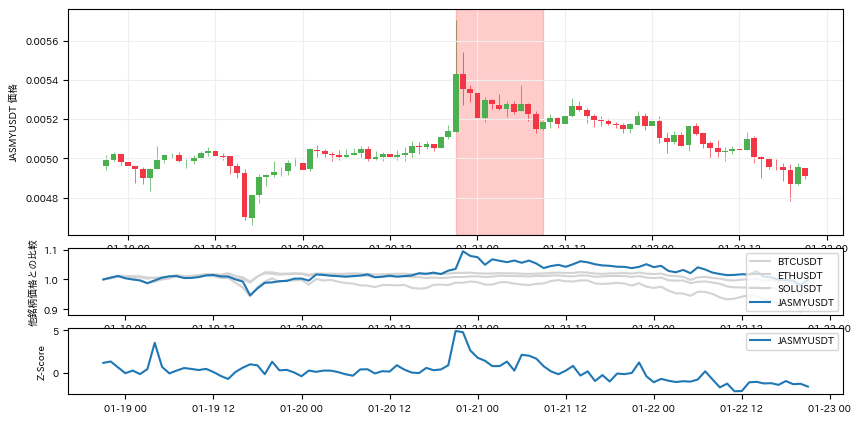

In [42]:
plot_price_and_zscore(anomaly_indices['JASMYUSDT'][2], 'JASMYUSDT')

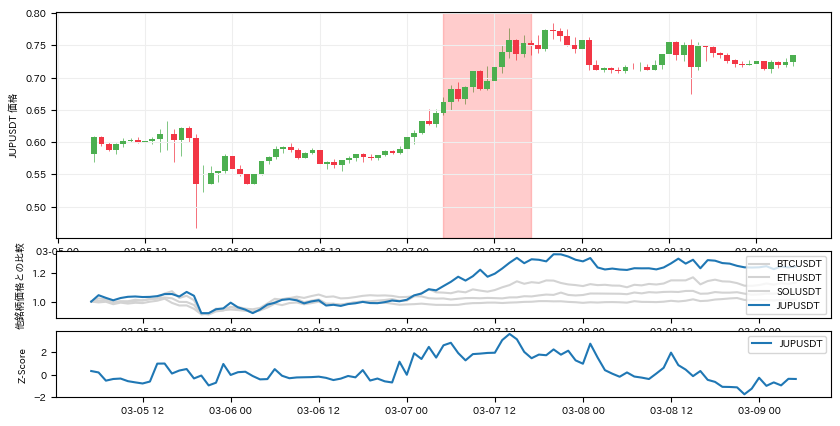

In [43]:
plot_price_and_zscore(anomaly_indices['JUPUSDT'][4], 'JUPUSDT')

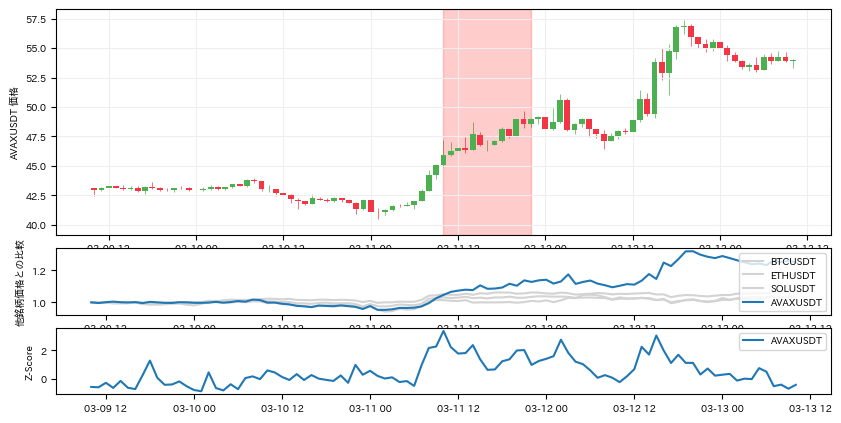

In [44]:
plot_price_and_zscore(anomaly_indices['AVAXUSDT'][3], 'AVAXUSDT')

## まとめと課題

- 他の銘柄の値動きとZスコアで比較することで、独自の値動きをしている箇所を検出可能。
- 今回は一変量だったため、値動きのない箇所もある。価格などを含めて多変量にすれば値動きのある箇所を検出しやすくなる。
- これをいろいろと活かせる
  - 人が集まるところの挙動の分析
  - ラベル付けに利用して、学習データとして利用する、あるいは除去する
  - ストラテジーに組み込む
  - 逆にこの期間の取引を控える　など。

# 結論

- 異常検出の概要や手法について確認した。
- 今回は原始的な統計的手法を紹介したが、それだけでも使えるところは多いはず。必要に応じて機械学習などのより洗練された手法を使うのもよい。
